# Assignment 4: Approximate Dynamic Programming 
## by Buelent Uendes

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from time import process_time
import matplotlib.pyplot as plt
from IPython.display import Image
import random

# Importing previous code from Assignment 3

In [2]:
# Reward function

def reward_function(x, a, N):
    if a == 0:
        return -(x/N)**2 
    else:
        return -(x/N)**2 - 0.01
    
#Transition function

def transition_function(N, p, q_high, q_low, x, a):
    #First get the increment for the increase in que lenght
    I = np.random.binomial(1,p)
    
    if a == 1:
        S = np.random.binomial(1, q_high)
    else:
        S = np.random.binomial(1, q_low)
    
    return min(N-1, max(x+I-S,0)) 

# Reward function 

def reward_policy_function(N, lazy = True):
    output = []
    if lazy == True:
        for i in range(0,N):
            output.append(reward_function(i, 0,N))
    else:
        for i in range(0,N):
            if i < 50:
                output.append(reward_function(i,0,N))
            else:
                output.append(reward_function(i,1,N))
            
    return np.asarray(output)

# Model the transition probability function

def transition_probability_function(N, p, q_high, q_low, lazy = True):
    #Rows represent the current state
    #Columns represent the next state
    
    #Initiliaze the matrix
    
    P = np.zeros((N,N))
    
    #Lazy policy
    if lazy == True:
        #Same effort for different que length if lazy policy
        q_1 = q_low 
        q_2 = q_low
    else:
        #Different effort for different que length if aggressive policy
        q_1 = q_low
        q_2 = q_high
        
    for i in range(0,N): #Go through columns
        if i < 50:
            q = q_1
        else:
            q = q_2
        for j in range(0,N):#Go through rows
            if i == j == 0:
                P[i,j] = p * q + (1-p) * (1-q) + (1-p) * q
            elif i == j == 99:
                P[i,j] = p * q + p * (1-q) + (1-p) * (1-q)
            elif i == j:
                P[i,j] = p * q + (1-p) * (1-q)
            elif (j - i) == 1:
                P[i,j] = p * (1-q)            
            elif (j - i) == -1:
                P[i,j] = (1-p) * q
    return P

def value_function_bellman(N, gamma,p,q_high, q_low, lazy = True):
    if lazy == True:
        dummy = True
    else:
        dummy = False
    
    A = np.identity(N) - gamma* transition_probability_function(N, p, q_high, q_low, lazy = dummy)
    A_inv = np.linalg.inv(A)
    r = reward_policy_function(N, lazy = dummy)
    return A_inv @ r 


# Additional functions that are needed

In [3]:
# Model the sample transitions

def sample_transitions(x_init,p, N, K, q_high, q_low, lazy = True):
    output = []
    x = x_init
    if lazy == True:
        effort = 0 #Lazy
        for i in range(0,K): #Loop over how many sample transitions I want to get
            x_new = transition_function(N, p, q_high, q_low, x, effort)
            output.append(x_new)
            x = x_new
    else:
        for i in range(0,K):
            if x<50:
                effort = 0
            else:
                effort = 1
            x_new = transition_function(N, p, q_high, q_low, x, effort)
            output.append(x_new)
            x = x_new    
    return output


## Problem description 

The task is to evaluate simple policies and find near-optimal policies via temporal-difference learning methods and linear function approximation. 

# Linear functions

In [67]:
def fine_feature_map(x,N):
    return np.asarray([1 if i == x else 0 for i in range(0, N)])

In [68]:
def coarse_feature_map(x,N):
    return np.asarray([1 if x in np.arange(5*(i-1),(5*i-1)+1) else 0 for i in range(1, int((N/5)+1))])

In [69]:
def piecewise_linear_feature_map(x,N):
    a = np.asarray([1 if x in np.arange(5*(i-1),(5*i-1)+1) else 0 for i in range(1, int((N/5)+1))])
    b = np.asarray([(1 * (x-5*(i-1))/5) if x in np.arange(5*(i-1),(5*i-1)+1) else 0 for i in range(1,int((N/5)+1))])
    return np.hstack((a,b))

In [71]:
test

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Problem 1: Approximate policy evaluation

The first problem is to study the performance of the same simple policies as in the first problem set, but this time using TD(0) and LSTD with $10^{4}$ , $10^{5}$ , $10^{6}$ , and $10^{7}$ sample transitions, under the three feature maps. Sample the transitions from one single episode starting from initial state x 0 = N (a full queue). Plot the resulting value functions and compare them to the results you have obtained in the first problem set.

The TD(0) algorithm is defined in the following way: 

In [7]:
Image(url= "TD(0)_LFA.png", width=500, height=500)

In [126]:
def init_theta(function = "fine_feature_map"):
    if function == "fine_feature_map":
        #return np.asarray(np.repeat(1, 100))
        return np.asarray(np.random.uniform(0,0.5, 100))
    if function == "coarse":
        #return np.asarray(np.repeat(1,20))
        return np.asarray(np.random.uniform(0,0.5, 20))
    if function == "pwl":
        #return np.asarray(np.repeat(0,40))
        return np.asarray(np.random.uniform(0,0.5, 40))

In [127]:
def td_zero_algorithm(gamma, a,b, transitions, N, lazy = True, function = "fine_feature_map", return_history = False):
    #Initialize the theta values
    theta_estimate = init_theta(function)
    history = [theta_estimate]
    for i in range(0, len(transitions)-1):
        #print(i)
        xt_0 = transitions[i]
        xt_1 = transitions[i+1] 
        alpha = a/(i + b)
        if lazy == True:
            a = 0
        else:
            if xt_0 >= 50:
                a = 1
            else:
                a = 0
        if function == "fine_feature_map":
            delta = reward_function(xt_0, a, N) + gamma * theta_estimate @ fine_feature_map(xt_1,N) - theta_estimate @ fine_feature_map(xt_0,N) 
            theta_estimate = theta_estimate + alpha * delta * fine_feature_map(xt_0,N)
        
        elif function == "coarse":
            delta = reward_function(xt_0, a, N) + gamma * theta_estimate @ coarse_feature_map(xt_1,N) - theta_estimate @ coarse_feature_map(xt_0,N) 
            theta_estimate = theta_estimate + alpha * delta * coarse_feature_map(xt_0,N)
            
        elif function == "pwl":
            delta = reward_function(xt_0, a, N) + gamma * theta_estimate @ piecewise_linear_feature_map(xt_1,N) - theta_estimate @ piecewise_linear_feature_map(xt_0,N) 
            theta_estimate = theta_estimate + alpha * delta * piecewise_linear_feature_map(xt_0,N)
        
        history.append(theta_estimate)
    
    if return_history == "True":
        return history
    else:
        return theta_estimate

In [128]:
def approximate_value_function(theta, N, function = "fine_feature_map"):
    if function == "fine_feature_map":
        return np.asarray([theta @  fine_feature_map(i, N) for i in range(0, N)])
    if function == "coarse":
        return np.asarray([theta @  coarse_feature_map(i, N) for i in range(0, N)])
    if function == "pwl":
        return np.asarray([theta @  piecewise_linear_feature_map(i, N) for i in range(0, N)])
    

In [144]:
#Set the parameters:

N_1 = 10**3
N_2 = 10**4
N_3 = 10**5
N_4 = 10**7

a = b = 10**5
sigma = 10**(-5)

q_low = 0.51
q_high = 0.6
p = 0.5
N = 100
x_init = 100
gamma = 0.9


In [145]:
agg_n1 = sample_transitions(x_init, p, N, N_1, q_high, q_low, lazy = False)
lazy_n1 = sample_transitions(x_init, p, N, N_1, q_high, q_low)
agg_n2 = sample_transitions(x_init, p, N, N_2, q_high, q_low, lazy = False)
lazy_n2 = sample_transitions(x_init, p, N, N_2, q_high, q_low)
agg_n3 = sample_transitions(x_init, p, N, N_3, q_high, q_low, lazy = False)
lazy_n3 = sample_transitions(x_init, p, N, N_3, q_high, q_low)


#lazy_n3 = sample_transitions(x_init, p, N, N_3, q_high, q_low)
#lazy_n4 = sample_transitions(x_init, p, N, N_4, q_high, q_low)

In [146]:
len(lazy_n2)

10000

# Run the simulations

In [148]:
# Lazy N1

theta_lazy_fine_n1 = td_zero_algorithm(gamma, a, b, lazy_n1, N, True, "fine_feature_map")
theta_lazy_coarse_n1 = td_zero_algorithm(gamma, a, b, lazy_n1, N, True, "coarse")
theta_lazy_pwl_n1 = td_zero_algorithm(gamma, a, b, lazy_n1, N, True, "pwl")

theta_lazy_values_n1 = {0: theta_lazy_fine_n1, 1: theta_lazy_coarse_n1, 2: theta_lazy_pwl_n1}

# Agg N1
#theta_agg_fine_n1 = td_zero_algorithm(gamma, a, b, agg_n1, N, lazy = False, function = "fine_feature_map")
#theta_agg_coarse_n1 = td_zero_algorithm(gamma, a, b, agg_n1, N, lazy = False, function = "coarse")
#theta_agg_pwl_n1 = td_zero_algorithm(gamma, a, b, agg_n1, N, lazy = False, function = "pwl")

#theta_agg_values_n1 = {0: theta_agg_fine_n1, 1: theta_agg_coarse_n1, 2: theta_agg_pwl_n1}

# Lazy N2:

theta_lazy_fine_n2 = td_zero_algorithm(gamma, a, b, lazy_n2, N, True, "fine_feature_map")
theta_lazy_coarse_n2 = td_zero_algorithm(gamma, a, b, lazy_n2, N, True, "coarse")
theta_lazy_pwl_n2 = td_zero_algorithm(gamma, a, b, lazy_n2, N, True, "pwl")

theta_lazy_values_n2 = {0: theta_lazy_fine_n2, 1: theta_lazy_coarse_n2, 2: theta_lazy_pwl_n2}

# Agg N2:
#theta_agg_fine_n2 = td_zero_algorithm(gamma, a, b, agg_n2, N, lazy = False, function = "fine_feature_map")
#theta_agg_coarse_n2 = td_zero_algorithm(gamma, a, b, agg_n2, N, lazy = False, function = "coarse")
#theta_agg_pwl_n2 = td_zero_algorithm(gamma, a, b, agg_n2, N, lazy = False, function = "pwl")

#theta_agg_values_n2 = {0: theta_agg_fine_n2, 1: theta_agg_coarse_n2, 2: theta_agg_pwl_n2}

# Lazy N3
theta_lazy_fine_n3 = td_zero_algorithm(gamma, a, b, lazy_n3, N, True, "fine_feature_map")
theta_lazy_coarse_n3 = td_zero_algorithm(gamma, a, b, lazy_n3, N, True, "coarse")
theta_lazy_pwl_n3 = td_zero_algorithm(gamma, a, b, lazy_n3, N, True, "pwl")

theta_lazy_values_n3 = {0: theta_lazy_fine_n3, 1: theta_lazy_coarse_n3, 2: theta_lazy_pwl_n3}

# Agg N2:
#theta_agg_fine_n3 = td_zero_algorithm(gamma, a, b, agg_n3, N, lazy = False, function = "fine_feature_map")
#theta_agg_coarse_n3 = td_zero_algorithm(gamma, a, b, agg_n3, N, lazy = False, function = "coarse")
#theta_agg_pwl_n3 = td_zero_algorithm(gamma, a, b, agg_n3, N, lazy = False, function = "pwl")

#theta_agg_values_n3 = {0: theta_agg_fine_n3, 1: theta_agg_coarse_n3, 2: theta_agg_pwl_n3}

# Calculate the approximate value functions

In [149]:
# Lazy_n1

value_lazy_n1 = []
value_lazy_n2 = []
value_lazy_n3 = []
value_agg_n1 = []
value_agg_n2 = []
value_agg_n3 = []

function = {0: "fine_feature_map", 1: "coarse", 2: "pwl"}
#theta_lazy_values_n1 = {0: theta_lazy_fine_n1, 1: theta_lazy_coarse_n1, 2: theta_lazy_pwl_n1}

for i in range(0,3):
    value_lazy_n1.append(approximate_value_function(theta_lazy_values_n1[i], N,function[i]))
    #agg_n1.append(approximate_value_function(theta_agg_values_n1[i], N,function[i]))
    
    value_lazy_n2.append(approximate_value_function(theta_lazy_values_n2[i], N,function[i]))
    #agg_n2.append(approximate_value_function(theta_agg_values_n2[i], N,function[i]))
    
    value_lazy_n3.append(approximate_value_function(theta_lazy_values_n3[i], N,function[i]))
    #agg_n3.append(approximate_value_function(theta_agg_values_n3[i], N,function[i]))


# Plot the results 

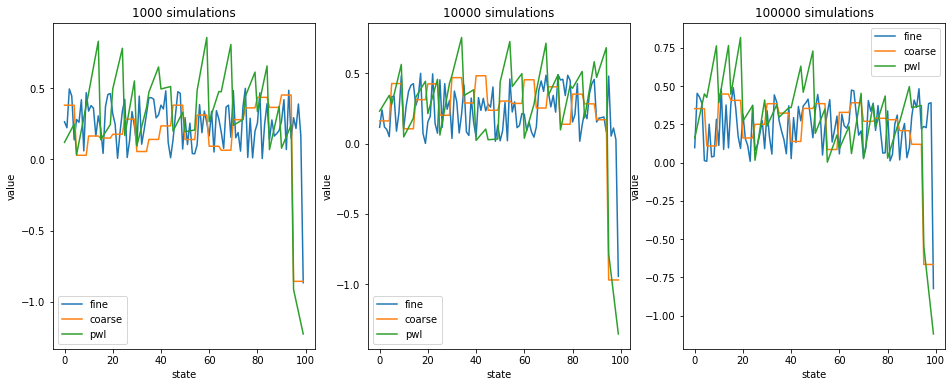

In [150]:
#Set the parameter and the style
x = np.arange(0,N)
plt.figure(figsize=(16, 6)) 

#First subplot
plt.subplot(1,3,1)
plt.plot(x, value_lazy_n1[0], label='fine')
plt.plot(x, value_lazy_n1[1], label='coarse')
plt.plot(x, value_lazy_n1[2], label='pwl')
plt.title('1000 simulations')
plt.ylabel('value')
plt.xlabel('state')
plt.legend()

plt.subplot(1,3,2)
plt.plot(x, value_lazy_n2[0], label='fine')
plt.plot(x, value_lazy_n2[1], label='coarse')
plt.plot(x, value_lazy_n2[2], label='pwl')
plt.title('10000 simulations')
plt.ylabel('value')
plt.xlabel('state')
plt.legend()

plt.subplot(1,3,3)
plt.plot(x, value_lazy_n3[0], label='fine')
plt.plot(x, value_lazy_n3[1], label='coarse')
plt.plot(x, value_lazy_n3[2], label='pwl')
plt.title('100000 simulations')
plt.ylabel('value')
plt.xlabel('state')
plt.legend()

plt.show()

Moreover, the LSTD(0) algorithm is described in the following pseudocode:

In [257]:
Image(url= "LSTD(0).png", width=500, height=500)